# Custom Federated Algorithms, Part 2: Implementing Federated Averaging

This tutorial is the second part of a two-part series that demonstrates how to
implement custom types of federated algorithms in TFF using the
[Federated Core (FC)](../federated_core.md), which serves as a foundation for
the [Federated Learning (FL)](../federated_learning.md) layer.

We encourage you to first read the
[first part of this series](custom_federated_algorithms_1.ipynb), which
introduce some of the key concepts and programming abstractions used here.

This second part of the series uses the mechanisms introduced in the first part
to implement a simple version of federated training and evaluation algorithms.

We encourage you to review the
[image classification](federated_learning_for_image_classification.ipynb) and
[text generation](federated_learning_for_text_generation.ipynb) tutorials for a
higher-level and more gentle introduction to TFF's Federated Learning APIs, as
they will help you put the concepts we describe here in context.

## Before we start

Before we start, try to run the following "Hello World" example to make sure
your environment is correctly setup. If it doesn't work, please refer to the
[Installation](../install.md) guide for instructions.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# NOTE: If you are running a Jupyter notebook and installing a locally built
# pip package, you may need to uncomment and run the following after editing
# the path to point to the '.whl' file on your local filesystem.
#
# import sys
# !{sys.executable} -m pip install tensorflow_federated-*.whl --user

import numpy as np
from six.moves import range
import tensorflow as tf

from tensorflow_federated import python as tff

tf.enable_resource_variables()

@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()

'Hello, World!'

## Implementing federated averaging

Now, let's use what we've learned so far to implement a simple version of
federated averaging. For symmetry with
[Federated Learning for Image Classification](federated_learning_for_image_classification.md),
we are going to use the MNIST example, but since this is intended as a low-level
tutorial, we are going to bypass the Keras API and `tff.simulation`, write raw
model code, and construct a federated data set from scratch.

### Preparing federated data sets

For the sake of a demonstration, we're going to simulate a scenario in which we
have data from 10 users, and each of the users contributes knowledge how to
recognize a different digit. This is about
non-[i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)
as it gets, and as such, it illustrates well the kind of challenges you may run
into working with federated data.

First, let's load the standard MNIST data from the TensorFlow website.

In [0]:
#@test {"output": "ignore"}
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

In [0]:
[(x.dtype, x.shape) for x in mnist_train]

[(dtype('uint8'), (60000, 28, 28)), (dtype('uint8'), (60000,))]

The data comes as Numpy arrays, one with images and another with digits, both
with the first dimension going over the individual examples. Let's write a
helper function that formats it in a way compatible with how we feed federated
sequences into TFF computations, i.e., as a list of lists - the outer list
ranging over the users (digits), the inner ones ranging over batches of data in
each client's sequence. As is customary, we will structure each batch as a pair
of tensors named `X` and `Y`, each with the leading batch dimension. While at
it, we'll also flatten each image into a 784-element vector and rescale the
pixels in it into the `0..1` range, so that we don't have to clutter the model
logic with data conversions.

In [0]:
NUM_EXAMPLES_PER_USER = 1000
BATCH_SIZE = 100

def get_data_for_digit(source, digit):
  output_sequence = []
  all_samples = [i for i, d in enumerate(source[1]) if d == digit]
  for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
    batch_samples = all_samples[i:i + BATCH_SIZE]
    output_sequence.append({
        'x': np.array([source[0][i].flatten() / 255.0 for i in batch_samples],
                      dtype=np.float32),
        'y': np.array([source[1][i] for i in batch_samples], dtype=np.int32)})
  return output_sequence

federated_train_data = [get_data_for_digit(mnist_train, d) for d in range(10)]

federated_test_data = [get_data_for_digit(mnist_test, d) for d in range(10)]

As a quick sanity check, let's look at the `Y` tensor in the last batch of data
contributed by the fifth client (the one corresponding to the digit `5`).

In [0]:
federated_train_data[5][-1]['y']

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

Just to be sure, let's also look at the image corresponding to the last element of that batch.

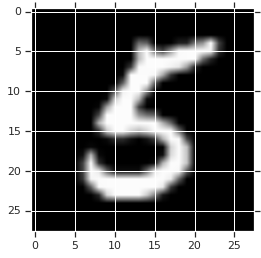

In [0]:
#@test {"output": "ignore"}
from matplotlib import pyplot as plt

plt.imshow(federated_train_data[5][-1]['x'][-1].reshape(28, 28), cmap='gray')
plt.show()

### Defining a loss function

Now that we have the data, let's define a loss function that we can use for
training. First, let's define the type of input as a TFF named tuple. Since the
size of data batches may vary, we set the batch dimension to `None` to indicate
that the size of this dimension is unknown.

In [0]:
BATCH_TYPE = tff.NamedTupleType([
    ('x', tff.TensorType(tf.float32, [None, 784])),
    ('y', tff.TensorType(tf.int32, [None]))])

str(BATCH_TYPE)

'<x=float32[?,784],y=int32[?]>'

You may be wondering why we can't just define an ordinary Python type. Recall
the discussion in one of the preceding sections, where we explained that while
we can express the logic of TFF computations using Python, under the hood TFF
computations *are not* Python. The symbol `BATCH_TYPE` defined above represents
an abstract TFF type specification. It is important to distinguish this
*abstract* TFF type from concrete Python *representation* types, e.g.,
containers such as `dict` or `collections.namedtuple` that may be used to
represent the TFF type in the body of a Python function. Unlike Python, TFF has
a single abstract type constructor `tff.NamedTupleType` for tuple-like
containers, with elements that can be individually named or left unnamed. This
type is also used to model formal parameters of computations, as TFF
computations can formally only declare one parameter and one result - you will
see examples of this shortly.

Let's now define the TFF type of model parameters, again as a TFF named tuple of
*weights* and *bias*.

In [0]:
MODEL_TYPE = tff.NamedTupleType([
    ('weights', tff.TensorType(tf.float32, [784, 10])),
    ('bias', tff.TensorType(tf.float32, [10]))])

str(MODEL_TYPE)

'<weights=float32[784,10],bias=float32[10]>'

With those definitions in place, now we can define the loss for a given model, over
a single batch. Note how in the body of `batch_loss`, we access named tuple
elements using the dot (`X.Y`) notation, as is standard for TFF.

In [0]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
  predicted_y = tf.nn.softmax(tf.matmul(batch.x, model.weights) + model.bias)
  return -tf.reduce_mean(tf.reduce_sum(
      tf.one_hot(batch.y, 10) * tf.log(predicted_y), reduction_indices=[1]))

As expected, computation `batch_loss` returns `float32` loss given the model and
a single data batch. Note how the `MODEL_TYPE` and `BATCH_TYPE` have been lumped
together into a 2-tuple of formal parameters; you can recognize the type of
`batch_loss` as `(<MODEL_TYPE,BATCH_TYPE> -> float32)`.

In [0]:
str(batch_loss.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,<x=float32[?,784],y=int32[?]>> -> float32)'

As a sanity check, let's construct an initial model filled with zeros and
compute the loss over the batch of data we visualized above.

In [0]:
initial_model = {
    'weights': np.zeros([784, 10], dtype=np.float32),
    'bias': np.zeros([10], dtype=np.float32)
}

sample_batch = federated_train_data[5][-1]

batch_loss(initial_model, sample_batch)

2.3025854

Note that we feed the TFF computation with the initial model defined as a
`dict`, even though the body of the Python function that defines it consumes
model parameters as `model.weight` and `model.bias`. Since, as explained
earlier, the logic of a TFF computation is defined in a glue language over
abstract TFF types, the choice of a physical Python container in this case
doesn't matter. The arguments of the call to `batch_loss` aren't simply passed
to the body of that function. Indeed, if you remember the earlier discussion in
the section on federated computations, the body of `batch_loss` has already been
traced earlier - that is, *before* the invocation, not after. TFF acts as the
caller to `batch_loss` at the computation definition time, and as the target of
invocation at the time `batch_loss` is invoked. In both roles, TFF serves as the
bridge between TFF's abstract type system and Python representation types. At
the invocation time, TFF will accept most standard Python container types
(`dict`, `list`, `tuple`, `collections.namedtuple`, etc.) as concrete
representations of abstract TFF tuples. Also, although as noted above, TFF
computations formally only accept a single parameter, you can use the familiar
Python call syntax with positional and/or keyword arguments in case where the
type of the parameter is a tuple - it works as expected.

### Gradient descent on a single batch

Now, let's define a computation that uses this loss function to perform a single
step of gradient descent. Note how in defining this function, we use
`batch_loss` as a subcomponent. You can always invoke a computation constructed
with `tff.tf_computation` inside the body of another computation.

In [0]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
  # Define a group of model variables and set them to `initial_model`.
  model_vars = tff.utils.get_variables('v', MODEL_TYPE)
  init_model = tff.utils.assign(model_vars, initial_model)

  # Perform one step of gradient descent using loss from `batch_loss`.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  with tf.control_dependencies([init_model]):
    train_model = optimizer.minimize(batch_loss(model_vars, batch))

  # Return the model vars after performing this gradient descent step.
  with tf.control_dependencies([train_model]):
    return tff.utils.identity(model_vars)

In [0]:
str(batch_train.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,<x=float32[?,784],y=int32[?]>,float32> -> <weights=float32[784,10],bias=float32[10]>)'

When you invoke a Python function decorated with `tff.tf_computation` within the
body of another such function, the logic of the inner TFF computation that gets
created is embedded in the logic of the outer one. You should ideally write your
code under the assumption that the inner and outer computations are, for the
most part, opaque to each other (thus, it's best to minimize the use of features
such as graph introspection or the use of collections). We are actively
experimenting with ways to support strong isolation between the inner and outer
computations, and if you rely on graph introspection, certain patterns may
break. That said, `batch_train` as written above does rely on the ability to
trace through the `batch_loss`'s graph in order to compute the gradients.

Now, let's apply this function a few times to the initial model to see whether
the loss decreases.

In [0]:
model = initial_model
losses = []
for _ in range(5):
  model = batch_train(model, sample_batch, 0.1)
  losses.append(batch_loss(model, sample_batch))

In [0]:
#@test {"output": "ignore"}
losses

[0.19690022, 0.13176313, 0.10113225, 0.082738116, 0.070301391]

### Gradient descent on a sequence of local data

Now, since `batch_train` appears to work, let's write a similar training
function `local_train` that consumes the entire sequence of all batches from one
user instead of just a single batch. The new computation will need to now
consume `tff.SequenceType(BATCH_TYPE)` instead of `BATCH_TYPE`.

In [0]:
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)

@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
def local_train(initial_model, learning_rate, all_batches):

  # Mapping function to apply to each batch.
  @tff.federated_computation(MODEL_TYPE, BATCH_TYPE)
  def batch_fn(model, batch):
    return batch_train(model, batch, learning_rate)

  return tff.sequence_reduce(all_batches, initial_model, batch_fn)

In [0]:
str(local_train.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,float32,<x=float32[?,784],y=int32[?]>*> -> <weights=float32[784,10],bias=float32[10]>)'

There are quite a few details buried in this short section of code, let's go
over them one by one.

First, while we could have implemented this logic entirely in TensorFlow,
relying on `tf.data.Dataset.reduce` to process the sequence similarly to how
we've done it earlier, we've opted this time to express the logic in the glue
language, as a `tff.federated_computation`. We've used the federated operator
`tff.sequence_reduce` to perform the reduction.

The operator `tff.sequence_reduce` is used similarly to
`tf.data.Dataset.reduce`. You can think of it as essentially the same as
`tf.data.Dataset.reduce`, but for use inside federated computations, which as
you may remember, cannot contain TensorFlow code. It as a template operator with
a formal parameter 3-tuple that consists of a *sequence* of `T`-typed elements,
the initial state of the reduction (we'll refer to it abstractly as *zero*) of
some type `U`, and the *reduction operator* of type `(U,T->U)` that alters the
state of the reduction by processing a single element. The result is the final
state of the reduction, after processing all elements in a sequential order. In
our example, the state of the reduction is the model trained on a prefix of the
data, and the elements are data batches.

Second, note that we have again used one computation (`batch_train`) as a
component within another (`local_train`), but not directly. We can't use it as a
reduction operator because it takes an additional parameter - the learning rate.

To work around the fact that `batch_train` takes an additional parameter, we
define an embedded federated computation `batch_fn` that binds to the
`local_train`'s parameter `learning_rate` in its body. It is allowed for a child
computation defined this way to capture a formal parameter of its parent as long
as the child computation is not invoked outside the body of its parent. You can
think of this pattern as an equivalent of `functools.partial` in Python.

The practical implication of capturing `learning_rate` this way is, of course,
that the same learning rate value is used across all batches.

Now, let's try the newly defined local training function on the entire sequence
of data from the same user who contributed the sample batch (digit `5`).

In [0]:
locally_trained_model = local_train(initial_model, 0.1, federated_train_data[5])

Did it work? To answer this question, we need to implement evaluation.

### Local evaluation

Here's one way to implement local evaluation by adding up the losses across all data
batches (we could have just as well computed the average; we'll leave it as an
exercise for the reader).

In [0]:
@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):
  # TODO(b/120157713): Replace with `tff.sequence_average()` once implemented.
  return tff.sequence_sum(
      tff.sequence_map(
          tff.federated_computation(lambda b: batch_loss(model, b), BATCH_TYPE),
          all_batches))

In [0]:
str(local_eval.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,<x=float32[?,784],y=int32[?]>*> -> float32)'

Again, there are a few new elements illustrated by this code, let's go over them
one by one.

First, we have used two new federated operators for processing sequences:
`tff.sequence_map` that takes a *mapping function* `T->U` and a *sequence* of
`T`, and emits a sequence of `U` obtained by applying the mapping function
pointwise, and `tff.sequence_sum` that just adds all the elements. Here, we map
each data batch to a loss value, and then add the resulting loss values to
compute the total loss.

Note that we could have again used `tff.sequence_reduce`, but this wouldn't be
the best choice - the reduction process is, by definition, sequential, whereas
the mapping and sum can be computed in parallel. When given a choice, it's best
to stick with operators that don't constrain implementation choices, so that
when our TFF computation is compiled in the future to be deployed to a specific
environment, one can take full advantage of all potential opportunities for a
faster, more scalable, more resource-efficient execution.

Second, note that just as in `local_train`, the component function we need
(`batch_loss`) takes more parameters than what the federated operator
(`tff.sequence_map`) expects - in this case, the operator wants a function that
maps batches to losses, but `batch_loss` also takes a model. Just as we did with
the learning rate, we use an embedded computation that captures the
`local_eval`'s model in its body in very much the same way we previously
captured `learning_rate` in `local_train`'s embedded computation `batch_fn`,
thus once again effectively defining a *partial* (a computation with a subset of
parameters bound, and the type signature modified to reflect this).

The one major difference compared to the previous example is that this time,
rather than defining a Python function with `tff.federated_computation` used as
a decorator, we've defined the computation inline, by invoking
`tff.federated_computation` as an ordinary function (not as a decorator), with a
Python lambda and a type signature as arguments. This inline style of defining
TFF computations mirrors the use of `lambda` expressions in Python, and can be a
good choice for short sections of code like this one.

Now, let's see whether our training worked.

In [0]:
local_eval(initial_model, federated_train_data[5])

23.025854

In [0]:
local_eval(locally_trained_model, federated_train_data[5])

0.43484691

Indeed, the loss decreased. But what happens if we evaluated it on another
user's data?

In [0]:
local_eval(initial_model, federated_train_data[0])

23.025854

In [0]:
local_eval(locally_trained_model, federated_train_data[0])

74.500748

As expected, things got worse. The model was trained to recognize `5`, and has
never seen a `0`. This brings the question - how did the local training impact
the quality of the model from the global perspective?

### Federated evaluation

This is the point in our journey where we finally circle back to federated types
and federated computations - the topic that we started with. Here's a pair of
TFF types definitions for the model that originates at the server, and the data
that remains on the clients.

In [0]:
SERVER_MODEL_TYPE = tff.FederatedType(MODEL_TYPE, tff.SERVER, all_equal=True)
CLIENT_DATA_TYPE = tff.FederatedType(LOCAL_DATA_TYPE, tff.CLIENTS)

With all the definitions introduced so far, expressing federated evaluation in
TFF is a one-liner - we distribute the model to clients, let each client invoke
local evaluation on its local portion of data, and then average out the loss.
Here's one way to write this.

In [0]:
@tff.federated_computation(SERVER_MODEL_TYPE, CLIENT_DATA_TYPE)
def federated_eval(model, data):
  return tff.federated_average(
      tff.federated_map(local_eval, [tff.federated_broadcast(model), data]))

We've already seen examples of `tff.federated_average` and `tff.federated_map`
in simpler scenarios, and at the intuitive level, they work as expected, but
there's more in this section of code than meets the eye, so let's go over it
carefully.

First, let's break down the *let each client invoke local evaluation on its
local portion of data* part. As you may recall from the preceding sections,
`local_eval` has a type signature of the form `(<MODEL_TYPE, LOCAL_DATA_TYPE> ->
float32)`.

The federated operator `tff.federated_map` is a template that accepts as a
parameter a 2-tuple that consists of the *mapping function* of some type `T->U`
and a federated value of type `{T}@CLIENTS` (i.e., with member constituents of
the same type as the parameter of the mapping function), and returns a result of
type `{U}@CLIENTS`.

Since we're feeding `local_eval` as a mapping function to apply on a per-client
basis, the second argument should be a federated of type `<MODEL_TYPE,
LOCAL_DATA_TYPE>@CLIENTS`, i.e., in the nomenclature of the preceding sections,
it should be a federated tuple. Each client should hold a full set of arguments
for `local_eval` as a member consituent. Instead, we're feeding it a 2-element
Python `list`. What's happening here?

Indeed, this is an example of an *implicit type cast* in TFF, similar to
implicit type casts you may have encountered elsewhere, e.g., when you feed an
`int` to a function that accepts a `float`. Implicit casting is used scarcily at
this point, but we plan to make it more pervasive in TFF as a way to minimize
boilerplate.

The implicit cast that's applied in this case is the equivalence between
federated tuples of the form `<X,Y>@Z`, and tuples of federated values
`<X@Z,Y@Z>`. While formally, these two are different type signatures, looking at
it from the programmers's perspective, each device in `Z` holds two units of
data `X` and `Y`. What happens here is not unlike `zip` in Python, and indeed,
we offer an operator `tff.federated_zip` that allows you to perform such
conversions explicity. When the `tff.federated_map` encounters a tuple as a
second argument, it simply invokes `tff.federated_zip` for you.

Given the above, you should now be able to recognize the expression
`tff.federated_broadcast(model)` as representing a value of TFF type
`{MODEL_TYPE}@CLIENTS`, and `data` as a value of TFF type
`{LOCAL_DATA_TYPE}@CLIENTS` (or simply `CLIENT_DATA_TYPE`), the two getting
filtered together through an implicit `tff.federated_zip` to form the second
argument to `tff.federated_map`.

The operator `tff.federated_broadcast`, as you'd expect, simply transfers data
from the server to the clients.

Now, let's see how our local training affected the average loss in the system.

In [0]:
federated_eval(initial_model, federated_train_data)

23.025852

In [0]:
federated_eval(locally_trained_model, federated_train_data)

54.432625

Indeed, as expected, the loss has increased. In order to improve the model for
all users, we'll need to train in on everyone's data.

### Federated training

The simplest way to implement federated training is to locally train, and then
average the models. This uses the same building blocks and patters we've already
discussed, as you can see below.

In [0]:
SERVER_FLOAT_TYPE = tff.FederatedType(tf.float32, tff.SERVER, all_equal=True)

@tff.federated_computation(
    SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE, CLIENT_DATA_TYPE)
def federated_train(model, learning_rate, data):
  return tff.federated_average(
      tff.federated_map(
          local_train,
          [tff.federated_broadcast(model),
           tff.federated_broadcast(learning_rate),
           data]))

In reality, rather than averaging the models, we prefer to average model deltas,
for a number of reasons, e.g., such as the ability to clip their norms, for
compression, etc. This is a relatively simple change in TFF, as you'll just need
to subtract the model from the argument to `tff.federated_average`, and then add
it back to the result - we omit it here to keep things simple.

Let's see whether the training works by running a few rounds of training and
comparing the average loss before and after.

In [0]:
#@test {"timeout": 600}
model = initial_model
learning_rate = 0.1
losses = []
for _ in range(5):
  model = federated_train(model, learning_rate, federated_train_data)
  learning_rate = learning_rate * 0.9
  losses.append(federated_eval(model, federated_train_data))

In [0]:
#@test {"output": "ignore"}
losses

[21.605524, 20.365679, 19.274801, 18.31111, 17.457254]

For completeness, let's now also run on the test data to confirm that our model
generalizes well.

In [0]:
federated_eval(initial_model, federated_test_data)

22.795593

In [0]:
federated_eval(model, federated_test_data)

17.278767

This concludes our tutorial.

Of course, our simplified example doesn't reflect a number of things you'd need
to do in a more realistic scenario - for example, we haven't computed metrics
other than loss. We encourage you to study
[the implementation](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/learning/federated_averaging.py)
of federated averaging in `tff.learning` as a more complete example, and as a
way to demonstrate some of the coding practices we'd like to encourage.